<a href="https://colab.research.google.com/github/Gautam0507/MAT496-Introduction-to-LLMs/blob/main/Chapter-2/Working_with_text_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is there in this notebook


Preparing Data for LLM Training
- Getting the datset
- Splitting it into tokens
- Encoding the words into vector representations
- Data Loading preparation to turn it into labelled data

# 2.1 Unserstanding word Embeddings


The concept of converting data into vector format is called *embedding*. Embedding is a mapping from discrete objects (files, audio, words) to points in a continuous vector space.

One of the most popular word encoding algorithm is called *Word2Vec*.

LLM's generally produce their own embeddings instead of using a pretrained model like Word2Vec. They usually produce thier own embeddings that are part of the input layer and are updated during training. This allows them to optimize the word embeddings to the specific task.

*embedding size* - the number of dimensions of the vectors that are used for embedding words

# 2.2 Tokenizing Text



We split the input text of the training data into individual tokens. The tokens are either individual words, special charachters, including punctuation charachters

## Downloading and Loading in data

In [ ]:
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/"
      "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
      "the-verdict.txt")
file_path = "verdict.txt"
urllib.request.urlretrieve(url, file_path)

('verdict.txt', <http.client.HTTPMessage at 0x785c4c7ffd50>)

In [ ]:
with open("verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
print("Total number of charachters: ", len(raw_text))
print(raw_text[:100])


Total number of charachters:  20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


## Splitting the words into tokens

We use the regex to split the words and punctuation

In [ ]:
import re
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print("The number of tokens (not necessarily distinct) presesnt in the text: ", len(preprocessed))

The number of tokens (not necessarily distinct) presesnt in the text:  4690


In [ ]:
print("A few of the tokens")
print(preprocessed[:30])

A few of the tokens
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


# 2.3 Converting tokens into token IDs


We convert the tokens from words to integer representations.

In [ ]:
# Determining the vocab size
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print("The size of the vocabulary (distinct tokens): ", vocab_size)

The size of the vocabulary (distinct tokens):  1130


The vocab is stored as key-value pair dictionary of (word, int token id)

In [ ]:
vocab = {token:integer for integer, token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
  print(item)
  if i >= 20:
    break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)


## Basic tokenizer class implementation

In [ ]:
class SimpleTokenizerV1:
  def __init__(self, vocab):
    self.str_to_int = vocab
    self.int_to_str = {i:s for s, i in vocab.items()}

  # Processes input text into token IDs
  def encode(self, text):
    preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
    preprocessed = [item.strip() for item in preprocessed if item.strip()]
    return [self.str_to_int[token] for token in preprocessed]

  # Converts token IDs back into text
  def decode(self, ids):
    text = " ".join([self.int_to_str[id] for id in ids])
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
    return text

tokenizing some text

In [ ]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know,"
Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


converting it back into text. Notice the change in It's to It' s in the output of decoder from the input  

In [ ]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


# 2.4 Adding special context tokens




The above tokenizer only encodes words it has seen before in the training data

We are adding 2 new tokens to encode this problem
- `<|unk|>` - unknown
- `<|endoftext|>` - end of the file / text (encodes that the context of one input is done and the next set of text is from another source)

There are other speical tokens that are used depending on the context of the model being trained.
- `[BOS]` - beginning of sequence (sequence context management)
- `[EOS]` - end of sequence (very similar to `<|endoftext|>`)
-  `[PAD]` - When using batch training. To ensure all texts have the same length.

The GPT tokenizers only use `<|endoftext|>` for encoding and no other special tokens

In [ ]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|unk|>", "<|endoftext|>"])
vocab = {token:integer for integer, token in enumerate(all_tokens)}
print("The new vocab size including special tokens:", len(vocab.items()))

The new vocab size including special tokens: 1132


In [ ]:
for i, item in enumerate(list(vocab.items())[-5:]):
  print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|unk|>', 1130)
('<|endoftext|>', 1131)


## Changing the above class to work with the new tokens

In [ ]:
class SimpleTokenizerV1:
  def __init__(self, vocab):
    self.str_to_int = vocab
    self.int_to_str = {i:s for s, i in vocab.items()}

  # Processes input text into token IDs
  def encode(self, text):
    preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
    preprocessed = [item.strip() for item in preprocessed if item.strip()]
    preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
    ids =  [self.str_to_int[s] for s in preprocessed]
    return ids

  # Converts token IDs back into text
  def decode(self, ids):
    text = " ".join([self.int_to_str[id] for id in ids])
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
    return text

In [ ]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


tokenizing the above text using the new tokenizer

In [ ]:
tokenizer = SimpleTokenizerV1(vocab)
id = tokenizer.encode(text)
print(id)

[1130, 5, 355, 1126, 628, 975, 10, 1131, 55, 988, 956, 984, 722, 988, 1130, 7]


In [ ]:
print(tokenizer.decode(id))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


# 2.5 Byte Pair Encoding


GPT models use this kind of encoding

The model above can use `<|endoftext|>` token and can encode and decode unknown words correctly.

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.7 MB/s eta 0:00:00


In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

encoding text

In [ ]:
text = ("Hello, do you like tea? <|endoftext|> In the sunlit terraces"
        "of someunknownPlace.")
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


decoding text

In [ ]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


The alorithm breaks down words it does not know into subword tokens or even charachter tokens to represent the word.

As we can see below there are only 2 words in the input but the output is composed of 6 tokens (subword tokens).
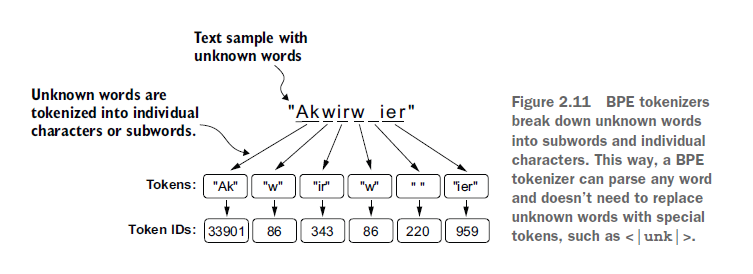

In [ ]:
tokens = tokenizer.encode("Akwirw ier")
print(tokens)

[33901, 86, 343, 86, 220, 959]


In [ ]:
print(tokenizer.decode(tokens))

Akwirw ier


# 2.6 Data Sampling with a sliding window



Create the dataset using input output pairs for training

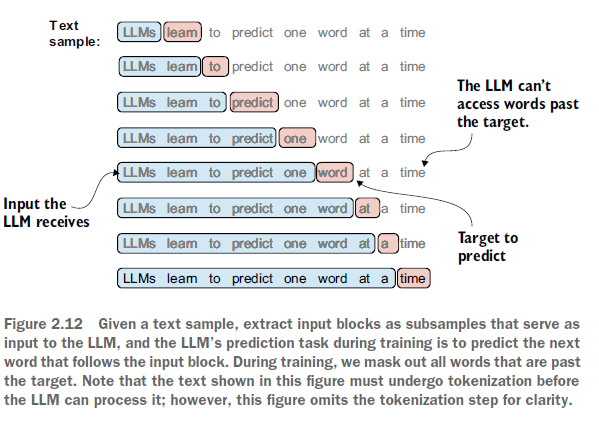

In [ ]:
with open("verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print("Total number of tokens in the training set:", len(enc_text))

Total number of tokens in the training set: 5145


In [ ]:
enc_sample = enc_text[50:]

Shifting the words by 1 gives us the input output pairs as data

In [ ]:
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [ ]:
print("Input", "----->", "Output")
for i in range(1, context_size + 1):
  context = enc_sample[:i]
  target = enc_sample[i]
  print(context, "----->" , target)
  print(tokenizer.decode(context), "----->", tokenizer.decode([target]))

Input -----> Output
[290] -----> 4920
 and ----->  established
[290, 4920] -----> 2241
 and established ----->  himself
[290, 4920, 2241] -----> 287
 and established himself ----->  in
[290, 4920, 2241, 287] -----> 257
 and established himself in ----->  a


## Making a DataLoader for this task
now we return the two tensors: an input tensor containing the text that the LLM sees and a target tensor that includes the targets for the
LLM to predict


Making a dataset for batched inputs and targets

Terms
- `txt` - input text that is made into a dataset
- `tokenizer` - passing in the tokenization algorithm that converts the `txt` into tokens
- `max_len` - Number of tokens to be taken. i.e context_window. The number of tokens taken as imput for prediction
- `stride` - The number of tokens to be skipped from one input to the next. i.e if input 1 starts from token 1 with a stride of 2 input 2 will start from token 3 and not token 2(next token). stride value of 1 acts as a sliding window of 1.
- `batch_size` - no of input tensors returned when the dataloader is called.

Sliding Window (Generating input output pair)
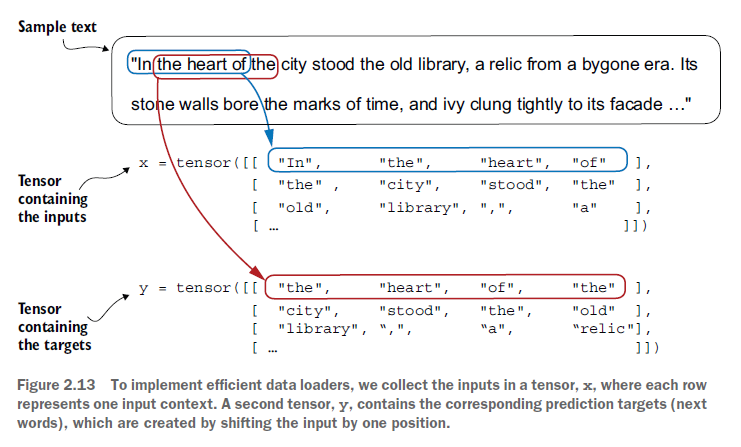

Explanation of Strides

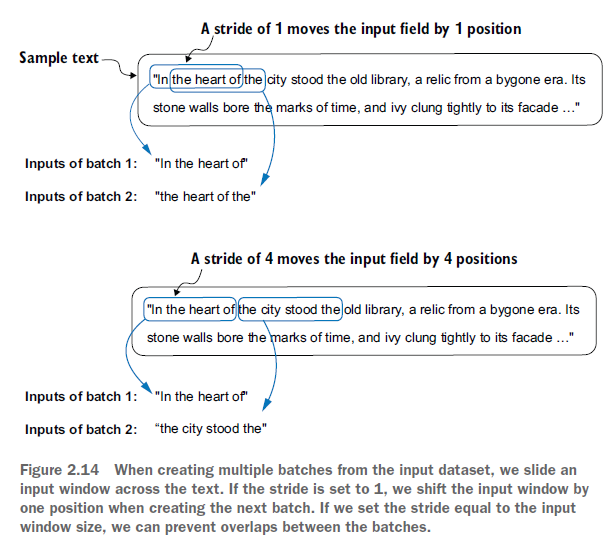

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []
    token_ids = tokenizer.encode(txt)
    for i in range(0, len(token_ids) - max_length, stride):
      input_chunk = token_ids[i:i + max_length]
      target_chunk = token_ids[i + 1:i + max_length + 1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]

Making the dataloader

In [ ]:
def create_dataloader_v1(txt, batch_size = 3, max_length = 256, stride = 128, shuffle = True, drop_last = True, num_workers = 0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(txt,tokenizer, max_length, stride)
  dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, drop_last = drop_last, num_workers = num_workers)

  return dataloader

In [ ]:
dataloader = create_dataloader_v1(raw_text)
print(next(iter(dataloader))[0].shape)

torch.Size([3, 256])


Change the function values above and see how shape changes

Testing the dataloader

In [ ]:
with open("verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
dataloader = create_dataloader_v1(raw_text, batch_size = 1, max_length = 4, stride = 1, shuffle = False)
data_iter = iter(dataloader) # iterating over dataloader
first_batch = next(data_iter)
print(first_batch)
second_batch = next(data_iter)
print(second_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


using batch size > 1

Increasing stride to 4 aoids overlap between the batches since more overlap could lead to increased overfitting

In [ ]:
dataloader = create_dataloader_v1(raw_text, batch_size = 8, max_length = 4, stride = 4, shuffle = False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


`batch_size` of 8 takes 8 inputs and targets at the same time.

Note that we increase the stride to 4 to utilize the data set fully (we don’t skip a single word). This avoids any overlap between the batches since more overlap could lead to
increased overfitting.

# 2.7 Creating token embeddings

GPT models train the word embeddings as part of the training process. For this we need to create token embeddings.

`embedding_layer` - This object in the code below contains one tensor with random values each of size `output_dim` for each word in the `vocab`. This way the object acts as a giant lookup table to find the embedding for any token given.
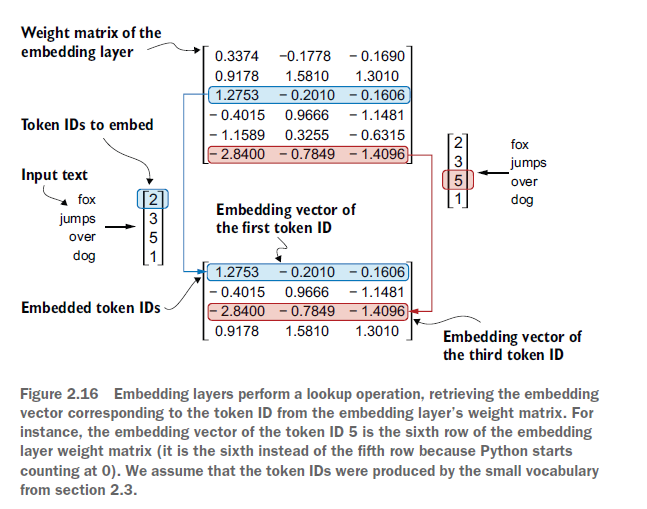

In [ ]:
input_ids = torch.tensor([2,3,5,1])
vocab_size = 6
output_dim = 3

In [ ]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


Looking up embedding for token 3

In [ ]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [ ]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


# 2.8 Encoding word positions

The self-attention mechanism used by LLMs does not encode the postion or order of the tokens within a sequence. This means that the same token ID gets encoded into the same vector representation regardless of its position. (Since the position of words can influence their meaning in drastic ways this is an issue that needs to be rectified)

*Relative Positional Embeddings*
It emphasises the distance between tokens. The advantage being the model generalises better to sequences of varying length.

*Absolute Positional Embeddings*

For each position in the sequence a unique embedding is aded to the token's embeddding to convey its exact location. Each position has a distinct embedding that is added


GPT Models use aboslute positional embeddings that are optimized during training instead of being fixed or predefined.

In [ ]:
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

Tokenization

In [ ]:
max_length = 4
batch_size = 8
dataloader = create_dataloader_v1(
    raw_text,
    batch_size = batch_size,
    max_length = max_length,
    stride = max_length,
    shuffle = False
  )
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs: \n", inputs)
print("\nInputs shape: \n", inputs.shape)


Token IDs: 
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape: 
 torch.Size([8, 4])


Embedding

In [ ]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


Creating Positional Embedding layer

The input to positional embeddings is `torch.arange(context_length)` which makes a sequence of $0,1,2, … context \ length -1$
- `context_length`  - represents the supported input size of the LLM. Since we are encoding positional data the `context_length` makes a good choice for this purpose


In [ ]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


The final input embeddings that are input into the LLM

In [ ]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


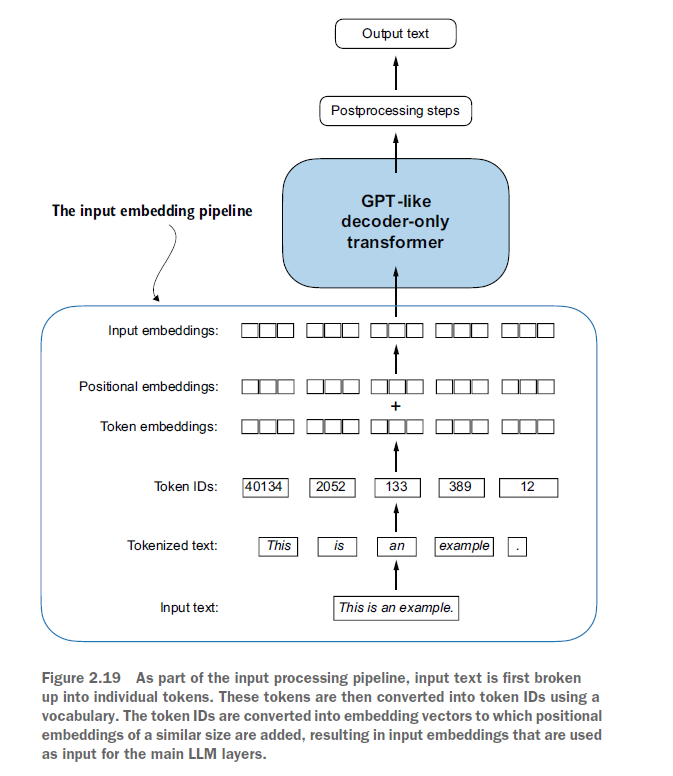

# TODO: Implement BPE from scratch

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

In [ ]:
from collections import defaultdict

word_freqs = defaultdict(int)

for text in corpus:
  words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
  new_words = [word for word, offset in words_with_offsets]
  for word in new_words:
    word_freqs[word] += 1

print(word_freqs)

defaultdict(<class 'int'>, {'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, '.': 4, 'Ġchapter': 1, 'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})


In [ ]:
alphabet = []

for word in word_freqs.keys():
  for letter in word:
    if letter not in alphabet:
      alphabet.append(letter)
alphabet.sort()

print(alphabet)

[',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


In [ ]:
vocab = ["<|endoftext|>"]+alphabet.copy()
splits = {word: [c for c in word] for word in word_freqs.keys()}

In [ ]:
def compute_pair_freqs(splits):
  pair_freqs = defaultdict(int)
  for word, freq in word_freqs.items():
    split = splits[word]
    if len(split) == 1:
      continue
    for i in range(len(split) - 1):
      pair = (split[i], split[i+1])
      pair_freqs[pair] += freq
  return pair_freqs


In [ ]:
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
  print(f"{key}: {pair_freqs[key]}")
  if i >= 5:
    break

('T', 'h'): 3
('h', 'i'): 3
('i', 's'): 5
('Ġ', 'i'): 2
('Ġ', 't'): 7
('t', 'h'): 3


In [ ]:
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
  if max_freq is None or max_freq < freq:
    best_pair = pair
    max_freq = freq

print(best_pair, max_freq)

('Ġ', 't') 7


In [ ]:
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

In [ ]:
def merge_pair(a,b,splits):
  for word in word_freqs:
    split = splits[word]
    if len(split) == 1:
      continue

    i = 0
    while i < len(split) - 1:
      if split[i] == a and split[i + 1] == b:
        split = split[:i] + [a+b] + split[i+2:]
      else:
        i += 1
    splits[word] = split
  return splits

In [ ]:
splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


In [ ]:
vocab_size = 50

while len(vocab) < vocab_size:
  pair_freqs = compute_pair_freqs(splits)
  best_pair= ""
  max_freq = None
  for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
      best_pair = pair
      max_freq = freq
  splits = merge_pair(*best_pair, splits)
  merges[best_pair] = best_pair[0] + best_pair[1]
  vocab.append(merges[best_pair])

In [ ]:
print(merges)

{('Ġ', 't'): 'Ġt', ('i', 's'): 'is', ('e', 'r'): 'er', ('Ġ', 'a'): 'Ġa', ('Ġt', 'o'): 'Ġto', ('e', 'n'): 'en', ('T', 'h'): 'Th', ('Th', 'is'): 'This', ('o', 'u'): 'ou', ('s', 'e'): 'se', ('Ġto', 'k'): 'Ġtok', ('Ġtok', 'en'): 'Ġtoken', ('n', 'd'): 'nd', ('Ġ', 'is'): 'Ġis', ('Ġt', 'h'): 'Ġth', ('Ġth', 'e'): 'Ġthe', ('i', 'n'): 'in', ('Ġa', 'b'): 'Ġab', ('Ġtoken', 'i'): 'Ġtokeni'}


In [ ]:
print(vocab)

['<|endoftext|>', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ', 'Ġt', 'is', 'er', 'Ġa', 'Ġto', 'en', 'Th', 'This', 'ou', 'se', 'Ġtok', 'Ġtoken', 'nd', 'Ġis', 'Ġth', 'Ġthe', 'in', 'Ġab', 'Ġtokeni']
